In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import gc
from pathlib import Path
import os

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from IPython.display import FileLink

import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

import PIL
from PIL import Image as PIL_IMG

import seaborn as sns

In [ ]:
!pip install pretrainedmodels

In [ ]:
import pretrainedmodels

In [ ]:
print("Fastai version: ", fastai.__version__)
print("PIL version: ", PIL.__version__)

In [ ]:
DATA_DIR = Path('../input')
IMGS_PATH = Path('../input/images/images/')

In [ ]:
[f for f in DATA_DIR.iterdir()]

In [ ]:
train_df = pd.read_csv(DATA_DIR/'train.csv')
test_df = pd.read_csv(DATA_DIR/'test.csv')

In [ ]:
label_mapper = {0: 'Cargo', 
                1: 'Military', 
                2: 'Carrier', 
                3: 'Cruise', 
                4: 'Tankers'}

In [ ]:
label_mapper_c2i = {v:i for i, v in label_mapper.items()}

In [ ]:
train_df['category'] = train_df['category'].map(label_mapper)

In [ ]:
train_df.head()

In [ ]:
train_df['category'].value_counts()

In [ ]:
# functions to get image statistics

def getSize(filename):
    
    """
    param filename : Image file name in string format
    returns : size of an image in Kilo Bytes
    """
    filename = IMGS_PATH/filename
    st = os.stat(filename)
    return st.st_size / 1024.0

def getDimensions(filename):
    """
    param filename : Image file name in string format
    returns : Image size (width, height) tuple
    """
    filename = IMGS_PATH/filename
    img_size = PIL_IMG.open(filename).size
    return img_size 

In [ ]:
train_img_sizes = train_df[~train_df['valid']]['image'].apply(getSize)
valid_img_sizes = train_df[train_df['valid']]['image'].apply(getSize)
test_img_sizes = test_df['image'].apply(getSize)

In [ ]:
fig ,ax = plt.subplots(ncols=3, nrows=1, figsize=(15,4))
for i, d in enumerate(zip([train_img_sizes, valid_img_sizes, test_img_sizes], ['train', 'validation', 'test'])):
    ax_s = sns.distplot(d[0], ax=ax[i])
    ax_s.set(title=d[1] + " file size distribution")
    
plt.tight_layout()
plt.show()

In [ ]:
train_img_dims = train_df[~train_df['valid']]['image'].apply(getDimensions)
valid_img_dims = train_df[train_df['valid']]['image'].apply(getDimensions)
test_img_dims = test_df['image'].apply(getDimensions)

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12,12))
for i, d in enumerate(zip([train_img_dims, valid_img_dims, test_img_dims], ['train', 'validation', 'test'])):
    widths = d[0].apply(lambda x: x[0])
    heights = d[0].apply(lambda x: x[1])
    ax_w = sns.distplot(widths, ax=ax[i][0])
    ax_w.set(title=d[1] + " width distribution")
    ax_h = sns.distplot(heights, ax=ax[i][1])
    ax_h.set(title=d[1] + " height distribution")

plt.tight_layout()
plt.show()

We have to change Width and height.

In [ ]:
(widths < heights).sum()

- Just 35 images, which has height greater than width in test data.

In [ ]:
def get_ex(path): return open_image(path)

def plots_f(path, tfms, rows, cols, width, height, **kwargs):
    [get_ex(path).apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(rows,cols,figsize=(width,height))[1].flatten())]

In [ ]:
tfms = get_transforms(max_rotate=5, xtra_tfms=[cutout(n_holes=(1,4), length=(7, 15), p=.5)])

In [ ]:
tfms

In [ ]:
open_image(IMGS_PATH/'2816925.jpg')

In [ ]:
plots_f(IMGS_PATH/'2816925.jpg', tfms, 2, 4, 12, 6, size=(140, 200))
# plots_f(IMGS_PATH/'2816925.jpg', tfms, 2, 4, 12, 6, size=(140, 200), padding_mode='border', resize_method=ResizeMethod.PAD)

In [ ]:
train_il = ImageList.from_df(df=train_df, cols='image', path=IMGS_PATH)
test_il = ImageList.from_df(df=test_df, cols='image', path=IMGS_PATH)

In [ ]:
np.random.seed(0)
src1 = (train_il
        .split_from_df(col='valid')
        .label_from_df(cols='category')
        .add_test(test_il))

In [ ]:
tfms1 = get_transforms(max_rotate=5, xtra_tfms=[cutout(n_holes=(1,5), length=(7, 15), p=.5)])
data1 = (src1
        .transform(tfms1, size=(224, 224))
        .databunch(path='.', bs=64)
        .normalize(imagenet_stats))

In [ ]:
data1

In [ ]:
data1.show_batch()

In [ ]:
print(pretrainedmodels.model_names)

In [ ]:
print(pretrainedmodels.pretrained_settings['se_resnext50_32x4d'])

In [ ]:
def model_f(pretrained=True, **kwargs):
    return pretrainedmodels.__dict__['se_resnext50_32x4d'](num_classes=1000, pretrained='imagenet')

def getLearner(data):
    learn1 = cnn_learner(data, model_f, metrics=[accuracy, FBeta(average='weighted')])
    return learn1

In [ ]:
learn1 = getLearner(data1)
# learn1 = cnn_learner(data1, models.resnet34, metrics=[accuracy, FBeta(average='weighted')])

In [ ]:
learn1.summary()

In [ ]:
learn1.lr_find()

In [ ]:
learn1.recorder.plot()

In [ ]:
!nvidia-smi

In [ ]:
sernxt50_stage1_callbacks = [CSVLogger(learn=learn1, filename='sernxt50_stage1_history'), ShowGraph(learn=learn1)]

In [ ]:
lr = (1e-2)/2
learn1.fit_one_cycle(8, slice(lr), callbacks=sernxt50_stage1_callbacks)

In [ ]:
learn1.save('sernxt50_stage1')

In [ ]:
learn1.unfreeze()
learn1.lr_find()
learn1.recorder.plot()

In [ ]:
sernxt50_stage2_callbacks = [CSVLogger(learn=learn1, filename='sernxt50_stage2_history'), ShowGraph(learn=learn1)]

In [ ]:
learn1.fit_one_cycle(28, slice((1e-4), lr/5), callbacks=sernxt50_stage2_callbacks)

In [ ]:
learn1.save('sernxt50-stage2')

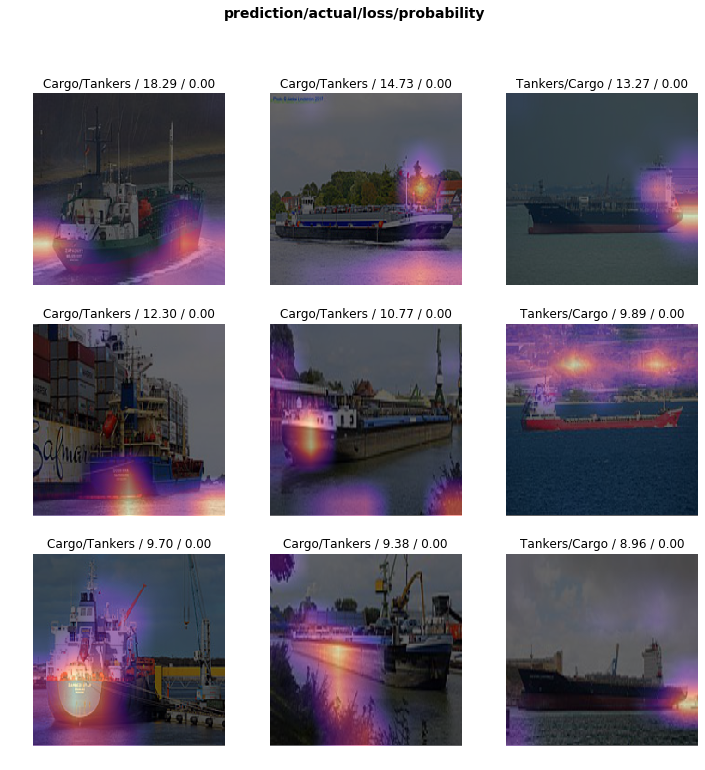

In [79]:
interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_top_losses(9)

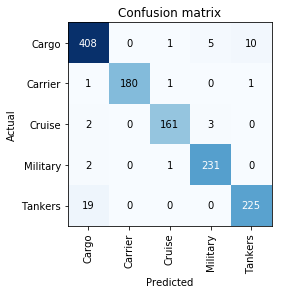

In [80]:
interp.plot_confusion_matrix()

As we can see that our algorithm is more confused about : Cargo and Tankers

In [81]:
from fastai.callbacks.hooks import *
import cv2
import matplotlib.pyplot as plt
import random

# hook into forward pass
def hooked_backward(m, oneBatch, cat):
    # we hook into the convolutional part = m[0] of the model
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(oneBatch)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

# We can create a utility function for getting a validation image with an activation map
def getHeatmap(val_index, learner, imgDataBunch):
    """Returns the validation set image and the activation map"""
    # this gets the model
    m = learner.model.eval()
    tensorImg,cl = imgDataBunch.valid_ds[val_index]
    # create a batch from the one image
    oneBatch,_ = imgDataBunch.one_item(tensorImg)
    oneBatch_im = vision.Image(imgDataBunch.denorm(oneBatch)[0])
    # convert batch tensor image to grayscale image with opencv
    cvIm = cv2.cvtColor(image2np(oneBatch_im.data), cv2.COLOR_RGB2GRAY)
    # attach hooks
    hook_a,hook_g = hooked_backward(m, oneBatch, cl)
    # get convolutional activations and average from channels
    acts = hook_a.stored[0].cpu()
    #avg_acts = acts.mean(0)

    # Grad-CAM
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    grad.shape,grad_chan.shape
    mult = (acts*grad_chan[...,None,None]).mean(0)
    return mult, cvIm

# Then, modify our plotting func a bit
def plot_heatmap_overview(interp:ClassificationInterpretation, learner, imgDataBunch, classes=['Cargo', 'Carrier', 'Cruise', 'Military', 'Tankers']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Grad-CAM\nPredicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = random.randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        act, im = getHeatmap(idx, learner, imgDataBunch)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        act, im = getHeatmap(idx, learner, imgDataBunch)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i].imshow(im)
        ax[1,i].imshow(im, cmap=plt.cm.gray)
        ax[1,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        act, im = getHeatmap(idx, learner, imgDataBunch)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i].imshow(im)
        ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

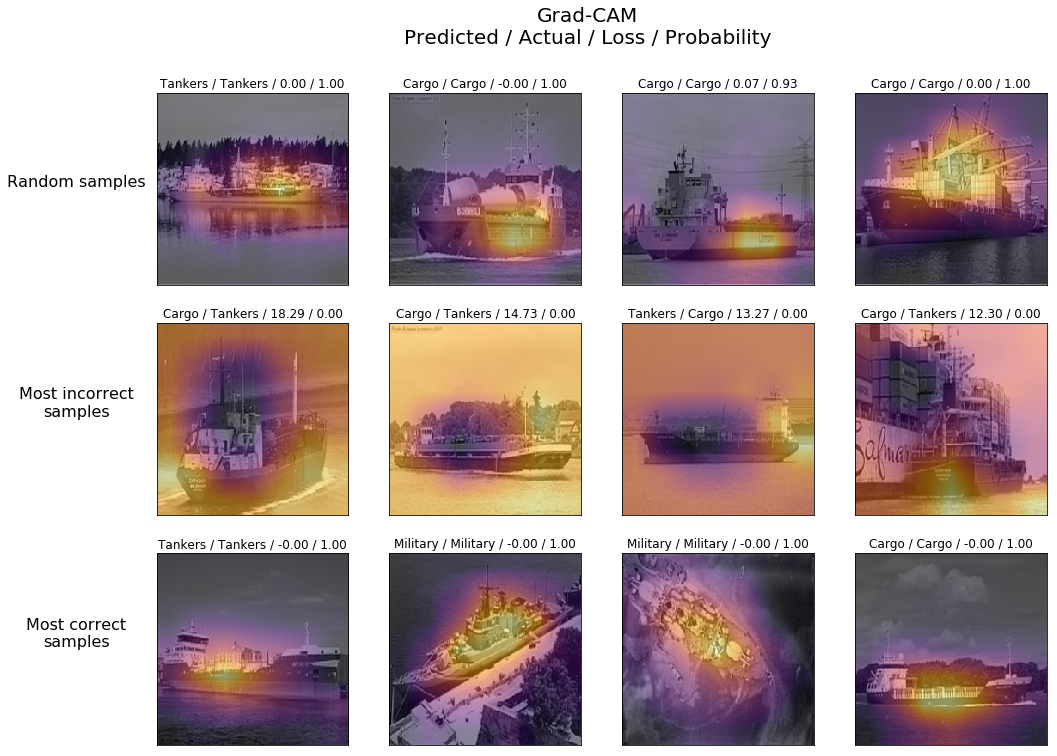

In [82]:
plot_heatmap_overview(interp, learn1, data1)

For 2nd image resolution images

data2 = (src1
        .transform(tfms1, size=(256, 256))
        .databunch(path='.', bs=256)
        .normalize(imagenet_stats))

data2.show_batch()

!nvidia-smi

learn1.data = data2

learn1.data

learn1.freeze()

learn1.lr_find()

learn1.recorder.plot()

rn32_stage1_im_callbacks = [CSVLogger(learn=learn1, filename='rn32_stage1_im_history'), ShowGraph(learn=learn1)]
lr = (1e-2)/2
learn1.fit_one_cycle(7, slice(lr), callbacks=rn32_stage1_im_callbacks)

learn1.save('rn32_im_stage1')

learn1.unfreeze()
learn1.lr_find()
learn1.recorder.plot()

rn32_stage2_im_callbacks = [CSVLogger(learn=learn1, filename='rn32_stage2_im_history'), ShowGraph(learn=learn1)]
lr = (1e-2)/2
learn1.fit_one_cycle(10, slice(1e-7, 1e-6), callbacks=rn32_stage2_im_callbacks)

In [83]:
fast_i2c = {v:i for i, v in learn1.data.train_ds.y.c2i.items()}

In [84]:
fast_i2c

{0: 'Cargo', 1: 'Carrier', 2: 'Cruise', 3: 'Military', 4: 'Tankers'}

In [85]:
val_preds_tta = learn1.TTA(ds_type=DatasetType.Valid)

In [86]:
accuracy_score(y_pred=val_preds_tta[0].argmax(1).numpy(), y_true=val_preds_tta[1].numpy())

0.964828137490008

In [87]:
f1_score(y_pred=val_preds_tta[0].argmax(1).numpy(), y_true=val_preds_tta[1].numpy(), average='weighted')

0.9647865270492461

In [88]:
val_preds = learn1.get_preds()

In [89]:
accuracy_score(y_pred=val_preds[0].argmax(1).numpy(), y_true=val_preds[1].numpy())

0.9632294164668266

In [90]:
f1_score(y_pred=val_preds[0].argmax(1).numpy(), y_true=val_preds[1].numpy(), average='weighted')

0.9631961761025396

In [91]:
c_counts = np.array([2120.0, 916.0, 832.0, 1167.0, 1217.0])
c_freqs = c_counts/c_counts.sum()
c_freqs

array([0.339091, 0.146513, 0.133077, 0.18666 , 0.194658])

In [103]:
x = val_preds[0].numpy() * c_freqs
x = x/x.sum(axis=1)[:, None]

In [105]:
f1_score(y_pred=x.argmax(1), y_true=val_preds[1].numpy(), average='weighted')

0.9631674012177172

In [106]:
!nvidia-smi

Thu Jun  6 04:44:50 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    36W / 250W |   2819MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [107]:
test_preds_tta = learn1.TTA(ds_type=DatasetType.Test)

In [108]:
test_preds = learn1.get_preds(ds_type=DatasetType.Test)

In [109]:
test_img_names = [Path(i).name for i in learn1.data.test_ds.x.items]

In [110]:
test_pred_tta_df = pd.DataFrame({'image': test_img_names})
test_pred_tta_df['category'] = test_preds_tta[0].argmax(1).numpy()

In [111]:
test_pred_df = pd.DataFrame({'image': test_img_names})
test_pred_df['category'] = test_preds[0].argmax(1).numpy()

In [112]:
test_pred_tta_df['category'] = test_pred_tta_df['category'].map(fast_i2c)
test_pred_tta_df['category'] = test_pred_tta_df['category'].map(label_mapper_c2i).astype(int) + 1

test_pred_df['category'] = test_pred_df['category'].map(fast_i2c)
test_pred_df['category'] = test_pred_df['category'].map(label_mapper_c2i).astype(int) + 1

In [113]:
test_pred_tta_df.to_csv('sernxt50_tta.csv', index=False)
test_pred_df.to_csv('sernxt50.csv', index=False)

In [114]:
# LB 0.96906864545064
FileLink('sernxt50.csv')

/kaggle/working/sernxt50.csv

In [115]:
# LB 0.973671914105878
FileLink('sernxt50_tta.csv')

/kaggle/working/sernxt50_tta.csv

In [125]:
ct_train_df = train_df[train_df['category'].isin(['Cargo', 'Tankers'])].copy()

In [126]:
ct_train_df['category'].value_counts()

Cargo      2120
Tankers    1217
Name: category, dtype: int64

In [127]:
ct_train_il = ImageList.from_df(df=ct_train_df, cols='image', path=IMGS_PATH)
np.random.seed(0)
ct_src = (ct_train_il
        .split_from_df(col='valid')
        .label_from_df(cols='category')
        )

ct_tfms = get_transforms(max_rotate=5, xtra_tfms=[cutout(n_holes=(1,5), length=(7, 15), p=.5)])
ct_data = (ct_src
        .transform(ct_tfms, size=(224, 224))
        .databunch(path='.', bs=64)
        .normalize(imagenet_stats))

In [128]:
ct_data

ImageDataBunch;

Train: LabelList (2669 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Cargo,Tankers,Cargo,Cargo,Cargo
Path: ../input/images/images;

Valid: LabelList (668 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Tankers,Tankers,Cargo,Tankers,Tankers
Path: ../input/images/images;

Test: None

In [129]:
ct_learn = getLearner(ct_data)
# learn1 = cnn_learner(data1, models.resnet34, metrics=[accuracy, FBeta(average='weighted')])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


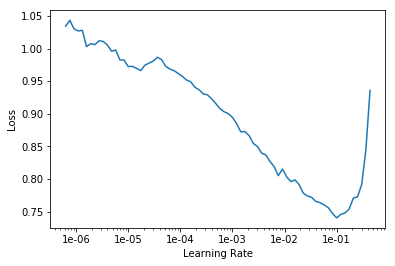

In [131]:
ct_learn.lr_find()
ct_learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.657283,0.454107,0.839820,0.839054,00:31
1,0.517923,0.425605,0.817365,0.815951,00:30
2,0.420200,0.342411,0.854790,0.854709,00:29
3,0.370680,0.348868,0.859281,0.858320,00:30
4,0.332782,0.334891,0.871257,0.870969,00:29
5,0.289799,0.312074,0.880240,0.879898,00:29
6,0.259875,0.317422,0.883234,0.882967,00:29
7,0.232781,0.322451,0.878743,0.878501,00:29


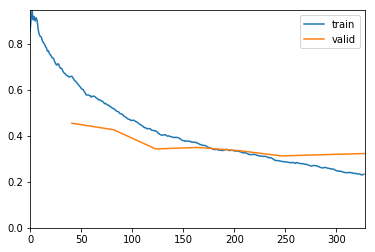

In [132]:
ct_sernxt50_stage1_callbacks = [CSVLogger(learn=ct_learn, filename='ct_sernxt50_stage1_history'), ShowGraph(learn=ct_learn)]
ct_lr = (1e-2)/2
ct_learn.fit_one_cycle(8, slice(ct_lr), callbacks=ct_sernxt50_stage1_callbacks)

In [133]:
ct_learn.save('ct_sernxt50-stage1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


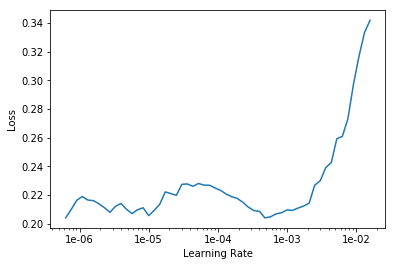

In [134]:
ct_learn.unfreeze()
ct_learn.lr_find()
ct_learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.218741,0.309076,0.883234,0.882572,00:32
1,0.193113,0.284127,0.893713,0.893433,00:32
2,0.171731,0.270793,0.904192,0.904192,00:32
3,0.135456,0.241321,0.911677,0.911625,00:32
4,0.104104,0.266657,0.911677,0.911432,00:32
5,0.089327,0.283991,0.905689,0.905490,00:32
6,0.070530,0.358977,0.904192,0.903333,00:32
7,0.066428,0.336865,0.928144,0.927309,00:32
8,0.057381,0.275045,0.929641,0.929672,00:31
9,0.041419,0.306143,0.923653,0.923432,00:31


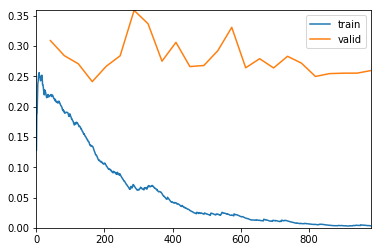

In [135]:
ct_sernxt50_stage2_callbacks = [CSVLogger(learn=ct_learn, filename='ct_sernxt50_stage2_history'), ShowGraph(learn=ct_learn)]
ct_learn.fit_one_cycle(24, slice(1e-4, ct_lr/5), callbacks=ct_sernxt50_stage2_callbacks)

In [136]:
ct_learn.save('ct_sernxt50-stage2')

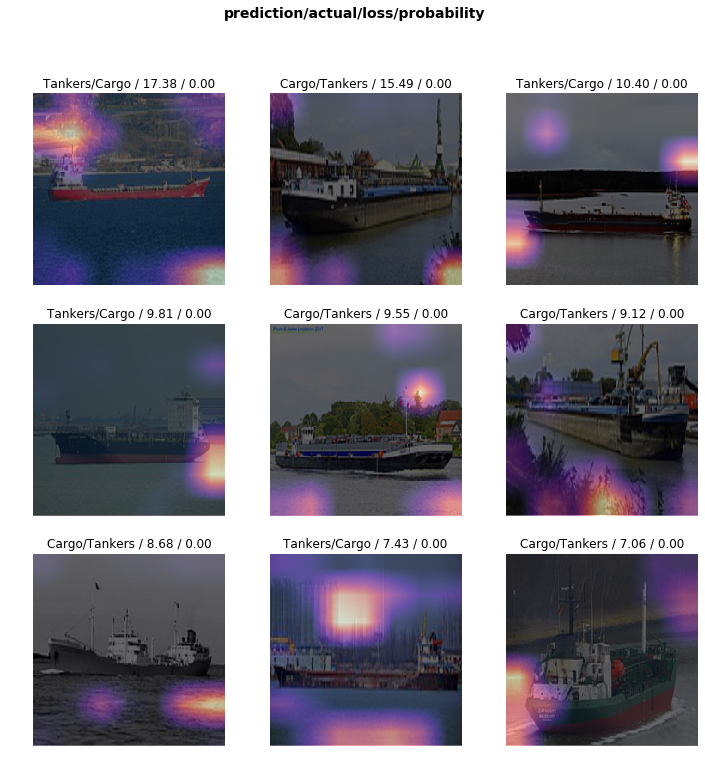

In [137]:
ct_interp = ClassificationInterpretation.from_learner(ct_learn)
ct_interp.plot_top_losses(9)

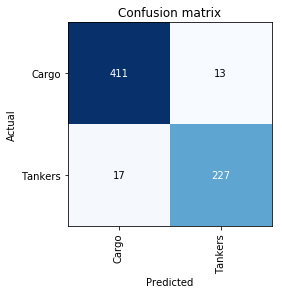

In [138]:
ct_interp.plot_confusion_matrix()

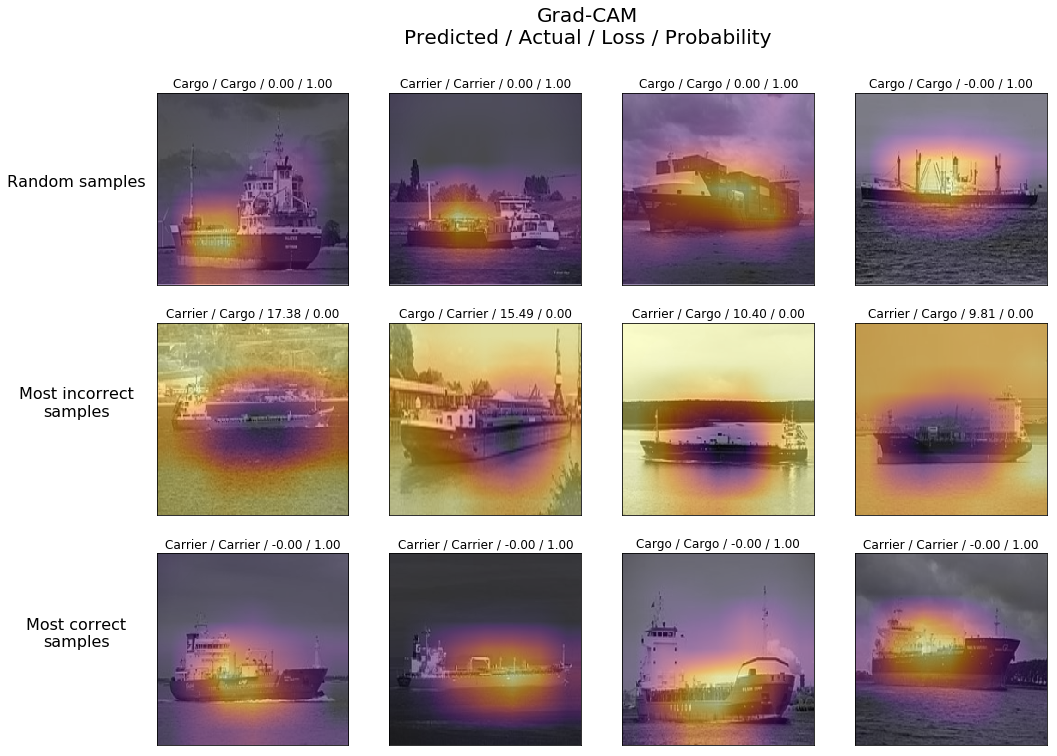

In [139]:
plot_heatmap_overview(ct_interp, ct_learn, ct_data)